## New York Taxi Analysis Data Analysis / Machine Learning project
### 1. Import Libraries

In [1]:
import pickle

import numpy as np
import pandas as pd
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

### 2. Import Data

In [2]:
taxi_oct_2024 = pd.read_parquet("./data/yellow_tripdata_2024-10.parquet")
taxi_data = pd.concat([taxi_oct_2024])
taxi_data.head()
taxi_data.shape

(3833771, 19)

### 3. Data Exploration

In [3]:
taxi_data.columns
taxi_data = pd.DataFrame(
    taxi_data[
        [
            "tpep_pickup_datetime",
            "tpep_dropoff_datetime",
            "passenger_count",
            "trip_distance",
            "RatecodeID",
            "PULocationID",
            "DOLocationID",
            "payment_type",
            "total_amount",
        ]
    ]
)

In [4]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2024-10-01 00:30:44,2024-10-01 00:48:26,1.0,3.0,1.0,162,246,1,24.9
1,2024-10-01 00:12:20,2024-10-01 00:25:25,1.0,2.2,1.0,48,236,1,23.0
2,2024-10-01 00:04:46,2024-10-01 00:13:52,1.0,2.7,1.0,142,24,1,22.2
3,2024-10-01 00:12:10,2024-10-01 00:23:01,1.0,3.1,1.0,233,75,1,21.2
4,2024-10-01 00:30:22,2024-10-01 00:30:39,1.0,0.0,1.0,262,262,3,8.0


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

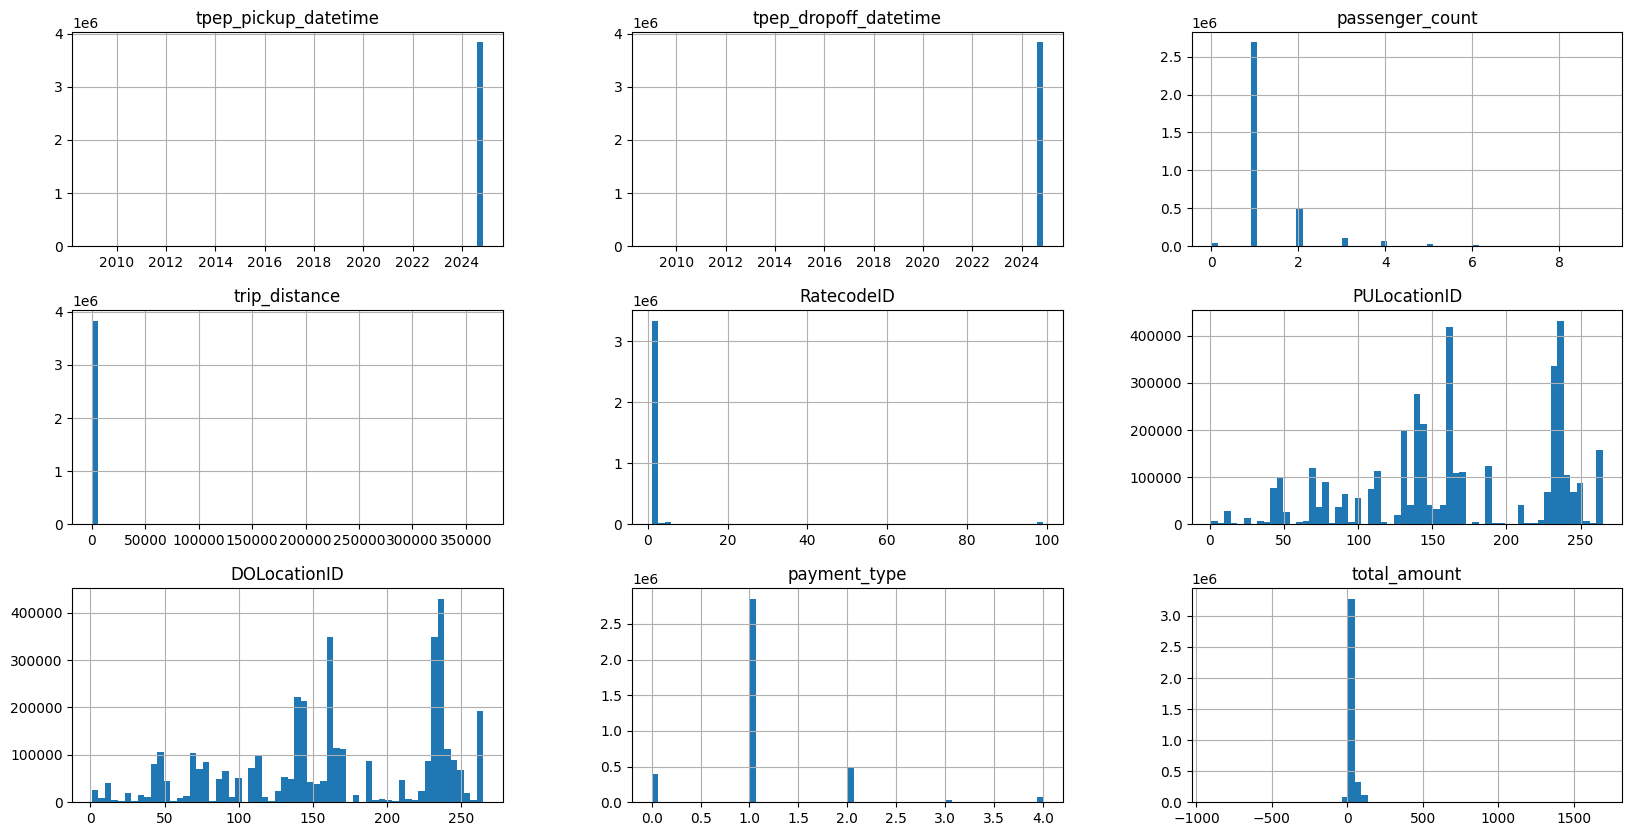

In [5]:
taxi_data.hist(figsize=(20, 10), bins=60)

In [6]:
taxi_data["RatecodeID"].value_counts()

RatecodeID
1.0     3200744
2.0      139764
99.0      43681
5.0       32694
3.0       12958
4.0       10024
6.0          11
Name: count, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

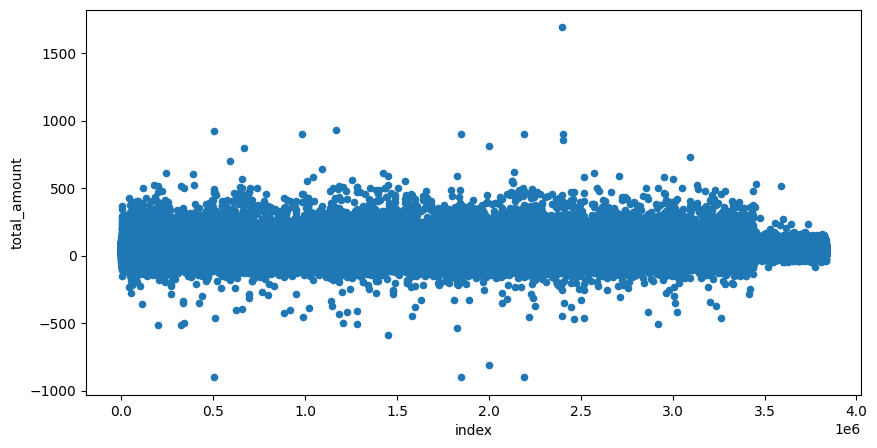

In [7]:
taxi_data.reset_index().plot(kind="scatter", y="total_amount", x="index", figsize=(10, 5))

Two things to deal with: -ve values and outliers (very high values)

(61426, 9)


<Axes: xlabel='index', ylabel='total_amount'>

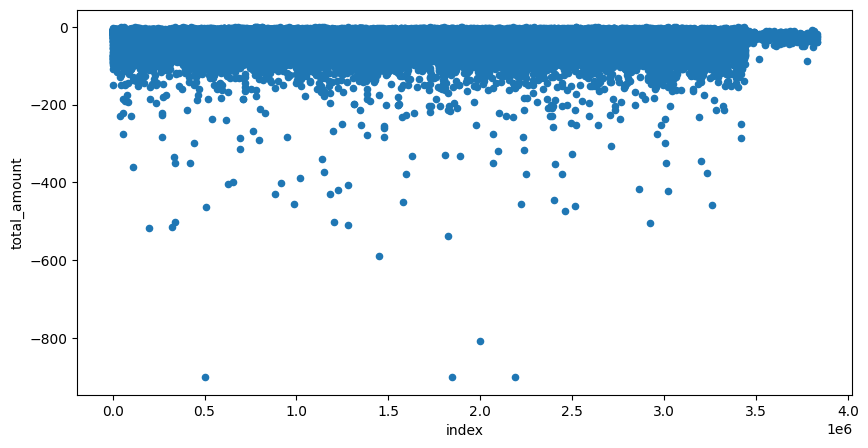

In [8]:
print(taxi_data[taxi_data["total_amount"] < 0].shape)
taxi_data[taxi_data["total_amount"] < 0].reset_index().plot(kind="scatter", y="total_amount", x="index", figsize=(10, 5))

    tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
17   2024-10-01 00:18:38   2024-10-01 00:36:47              2.0   
139  2024-10-01 00:43:38   2024-10-01 00:45:00              3.0   
162  2024-10-01 00:39:06   2024-10-01 00:55:16              1.0   
232  2024-10-01 00:35:51   2024-10-01 00:36:01              1.0   
257  2024-10-01 00:42:03   2024-10-01 00:45:53              1.0   

     trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
17            7.42         1.0           239           247             4   
139           0.05         1.0           230           230             4   
162           7.42         1.0           236           231             3   
232           0.00         1.0           238           238             3   
257           0.73         1.0           163            48             4   

     total_amount  
17          -38.1  
139          -8.7  
162         -36.0  
232          -6.0  
257         -10.8  
payment_type
4    37

<Axes: >

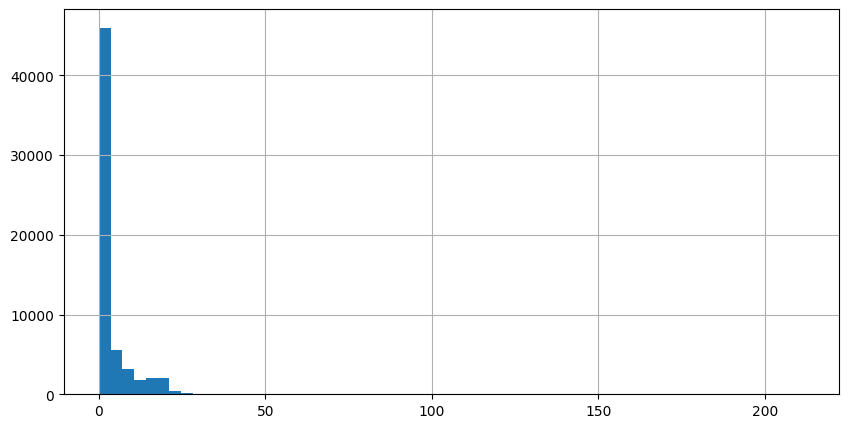

In [9]:
print(taxi_data[taxi_data["total_amount"] < 0].head())
print(taxi_data[taxi_data["total_amount"] < 0]["payment_type"].value_counts())  # type: ignore
taxi_data[taxi_data["total_amount"] < 0]["trip_distance"].hist(figsize=(10, 5), bins=60)  # type: ignore

Since most of the -ve fared trips are of type 3 and 4 (No Charge and Dispute) and of trip_distance 0, we can safely ignore them.

(432, 9)
      tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
5351   2024-10-01 07:41:33   2024-10-01 07:41:43              1.0   
9022   2024-10-01 08:11:48   2024-10-01 08:12:04              1.0   
9023   2024-10-01 08:12:11   2024-10-01 08:12:27              1.0   
15016  2024-10-01 09:58:38   2024-10-01 09:58:47              1.0   
19754  2024-10-01 10:25:58   2024-10-01 10:41:41              1.0   

       trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
5351             0.0        99.0           135           135             1   
9022             0.0         1.0           161           161             4   
9023             0.0         1.0           161           161             4   
15016            0.0        99.0           228           228             1   
19754            0.0         1.0            89            91             1   

       total_amount  
5351            0.0  
9022            0.0  
9023            0.0  
15016           0.0

<Axes: xlabel='index', ylabel='total_amount'>

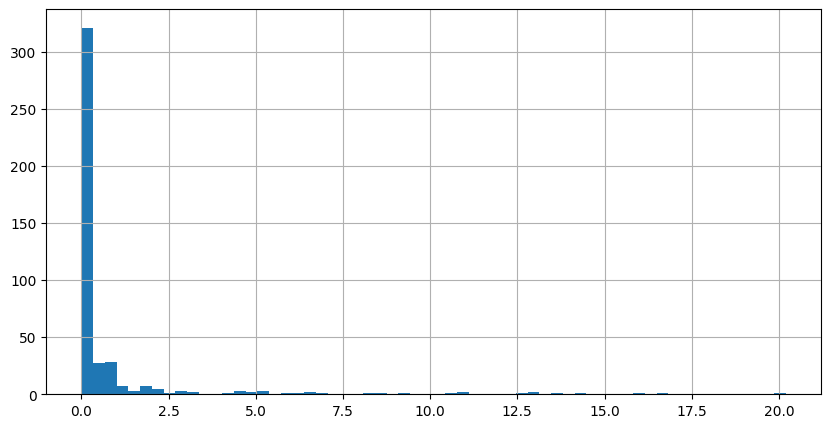

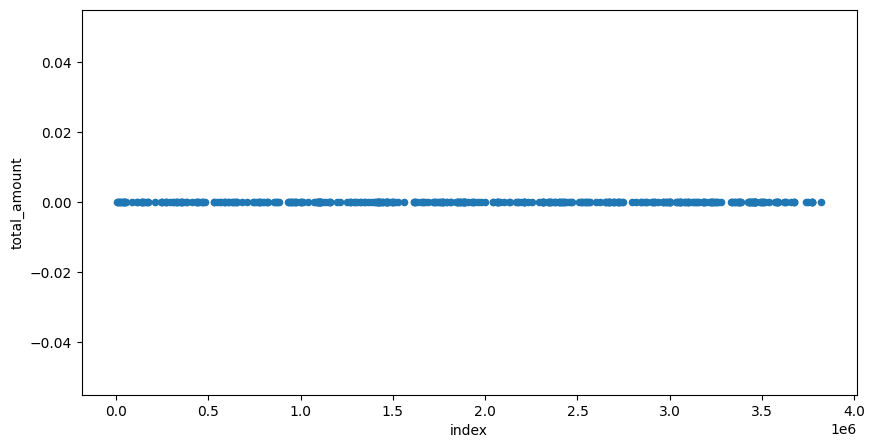

In [17]:
print(taxi_data[taxi_data["total_amount"] == 0].shape)
print(taxi_data[taxi_data["total_amount"] == 0].head())
print(taxi_data[taxi_data["total_amount"] == 0]["payment_type"].value_counts())  # type: ignore
taxi_data[taxi_data["total_amount"] == 0]["trip_distance"].hist(  # type: ignore
    figsize=(10, 5), bins=60
)
taxi_data[taxi_data["total_amount"] == 0].reset_index().plot(kind="scatter", y="total_amount", x="index", figsize=(10, 5))

Hence we can safely ignore -ves and 0's. But what about very high values?

In [18]:
print(taxi_data[taxi_data["total_amount"] > 250].shape)
print(taxi_data["total_amount"].mean())

(1350, 9)
28.42962879890323


Keep Total Amount less than $250

In [12]:
taxi_data_filtered = taxi_data[taxi_data["total_amount"].between(0, 250)]
print(taxi_data.shape)
print(taxi_data_filtered.shape)

(3833771, 9)
(3770995, 9)


In [15]:
### check for missing values
print(taxi_data_filtered.shape)
print(taxi_data_filtered.isna().sum())
taxi_data_filtered = taxi_data_filtered.dropna()
print(taxi_data_filtered.shape)

(3377357, 9)
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64
(3377357, 9)


### 5. Data Preperation

In [19]:

# make a copy of it
taxi_data_prepared = taxi_data_filtered.copy()

In [24]:

# check types
print(taxi_data_prepared.dtypes)

# fix types
taxi_data_prepared.loc[:, "tpep_pickup_datetime"] = pd.to_datetime(taxi_data_prepared.loc[:, "tpep_pickup_datetime"])
taxi_data_prepared.loc[:, "tpep_dropoff_datetime"] = pd.to_datetime(taxi_data_prepared.loc[:, "tpep_dropoff_datetime"])

taxi_data_prepared.loc[:, "passenger_count"] = taxi_data_prepared["passenger_count"].astype(int)
taxi_data_prepared.loc[:, "RatecodeID"] = taxi_data_prepared["RatecodeID"].astype(str)
taxi_data_prepared.loc[:, "PULocationID"] = taxi_data_prepared["PULocationID"].astype(str)
taxi_data_prepared.loc[:, "DOLocationID"] = taxi_data_prepared["DOLocationID"].astype(str)
taxi_data_prepared.loc[:, "payment_type"] = taxi_data_prepared["payment_type"].astype(str)
print()
print(taxi_data_prepared.dtypes)

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
transaction_date         datetime64[ns]
transaction_year                  int32
transaction_month                 int32
transaction_day                   int32
transaction_hour                  int32
dtype: object

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
transaction_date         datetime64[ns]
transaction_year         

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transaction_date'}>],
       [<Axes: title={'center': 'transaction_year'}>,
        <Axes: title={'center': 'transaction_month'}>,
        <Axes: title={'center': 'transaction_day'}>],
       [<Axes: title={'center': 'transaction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

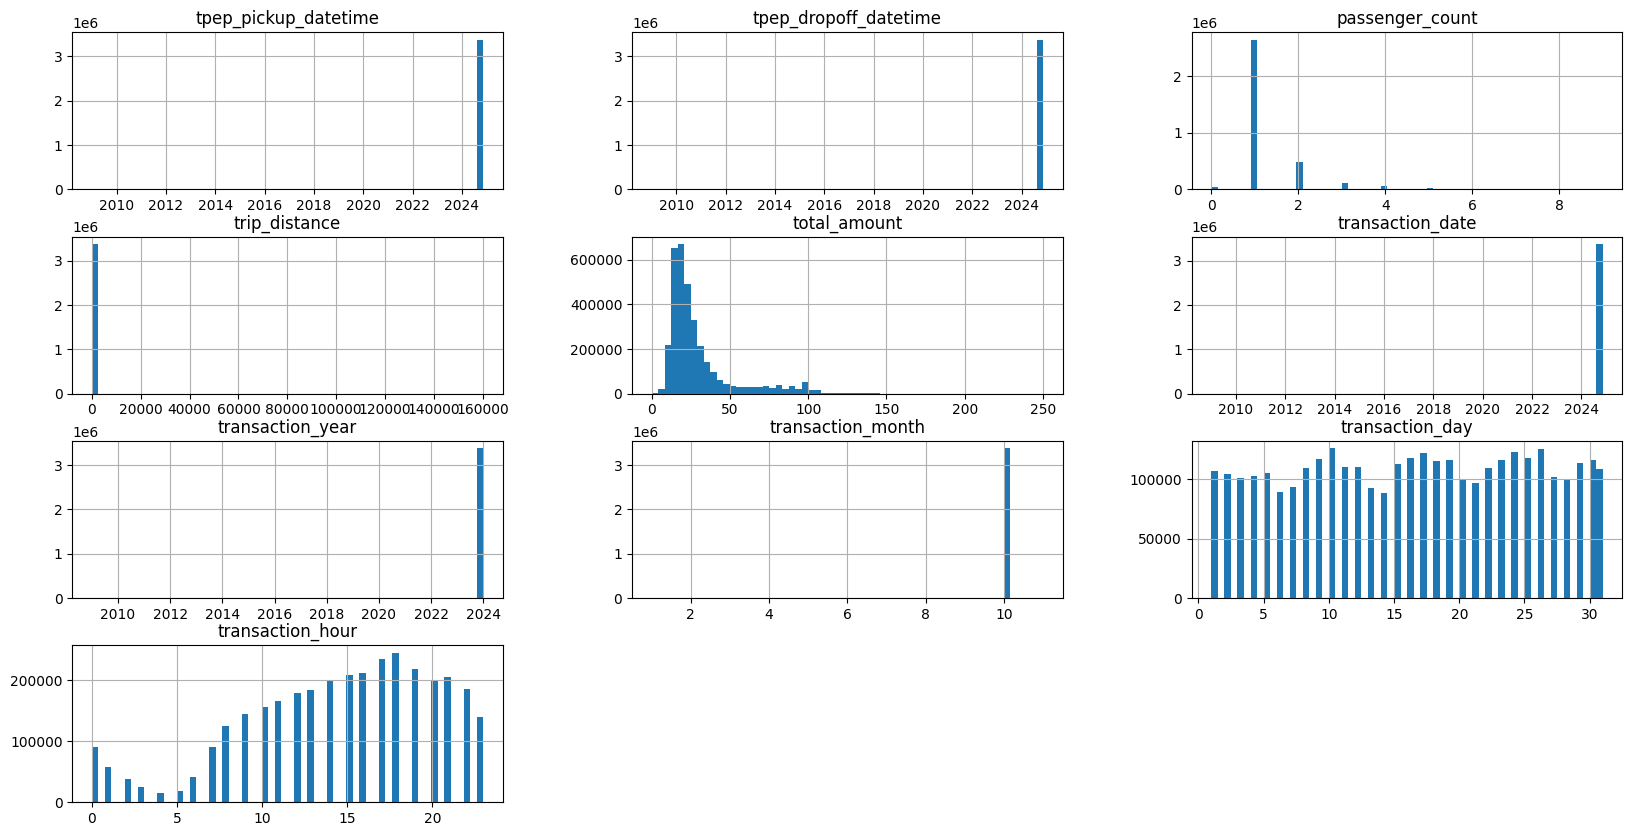

In [22]:

# we transform values into formats we need

taxi_data_prepared["transaction_date"] = pd.to_datetime(
    taxi_data_prepared["tpep_pickup_datetime"].dt.date  # type: ignore
)
taxi_data_prepared["transaction_year"] = taxi_data_prepared["tpep_pickup_datetime"].dt.year  # type: ignore
taxi_data_prepared["transaction_month"] = taxi_data_prepared["tpep_pickup_datetime"].dt.month  # type: ignore
taxi_data_prepared["transaction_day"] = taxi_data_prepared["tpep_pickup_datetime"].dt.day  # type: ignore
taxi_data_prepared["transaction_hour"] = taxi_data_prepared["tpep_pickup_datetime"].dt.hour  # type: ignore

taxi_data_prepared.head()
taxi_data_prepared.hist(figsize=(20, 10), bins=60)

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transaction_date'}>],
       [<Axes: title={'center': 'transaction_year'}>,
        <Axes: title={'center': 'transaction_month'}>,
        <Axes: title={'center': 'transaction_day'}>],
       [<Axes: title={'center': 'transaction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

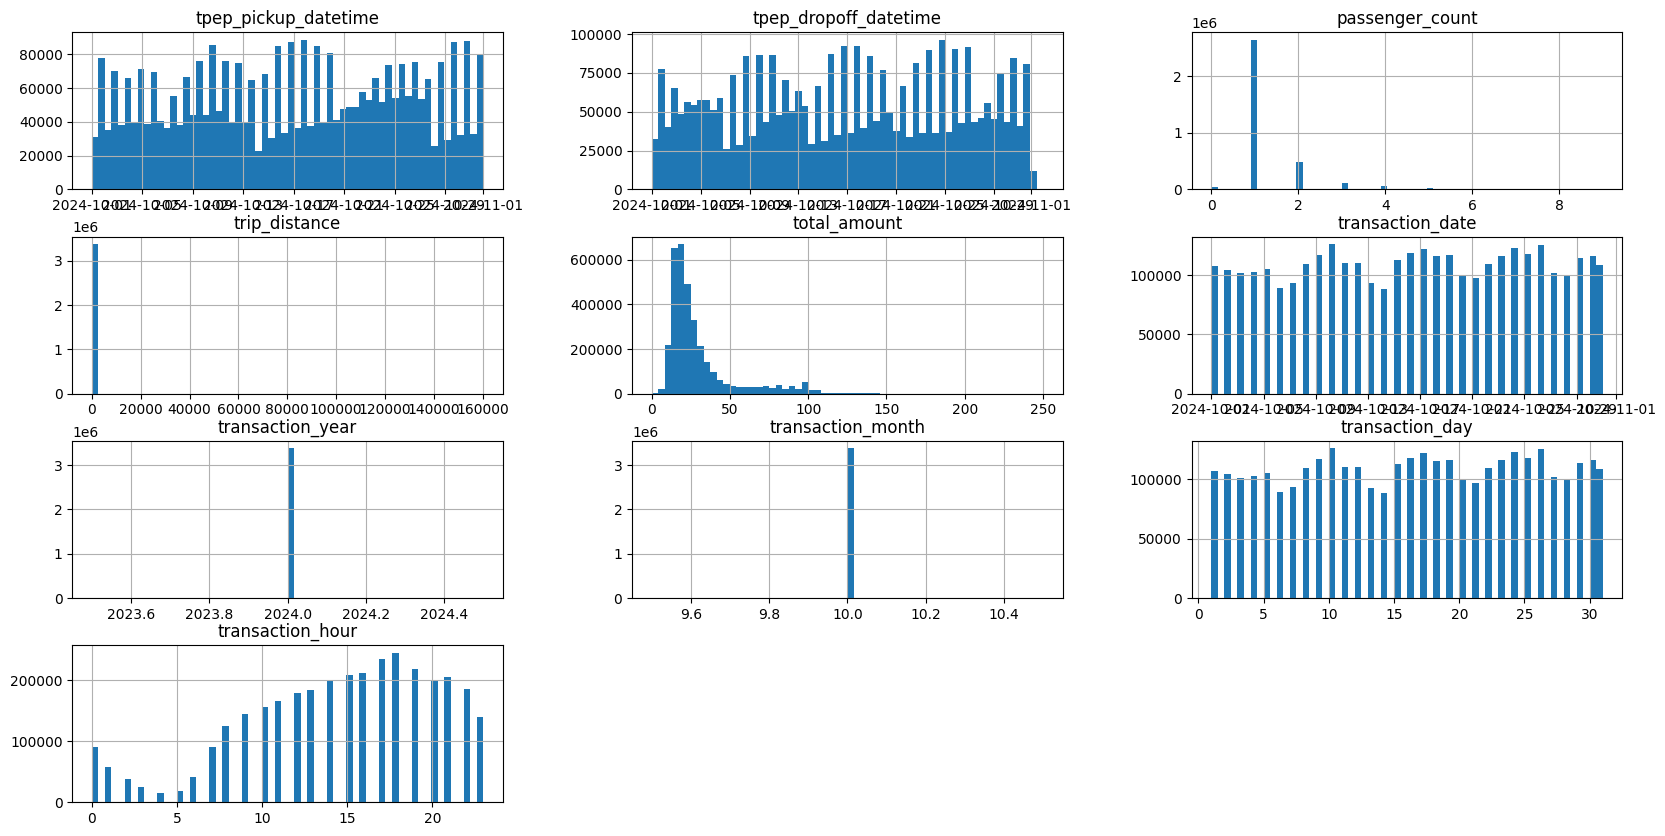

In [25]:

# fix year and month to 2024 10

taxi_data_prepared = taxi_data_prepared[taxi_data_prepared["transaction_year"] == 2024]
taxi_data_prepared = pd.DataFrame(taxi_data_prepared[taxi_data_prepared["transaction_month"] == 10])

taxi_data_prepared.hist(figsize=(20, 10), bins=60)

trip_distance too contains humongous values, guess we can remove > 100 (only 22 records)

(22, 14)


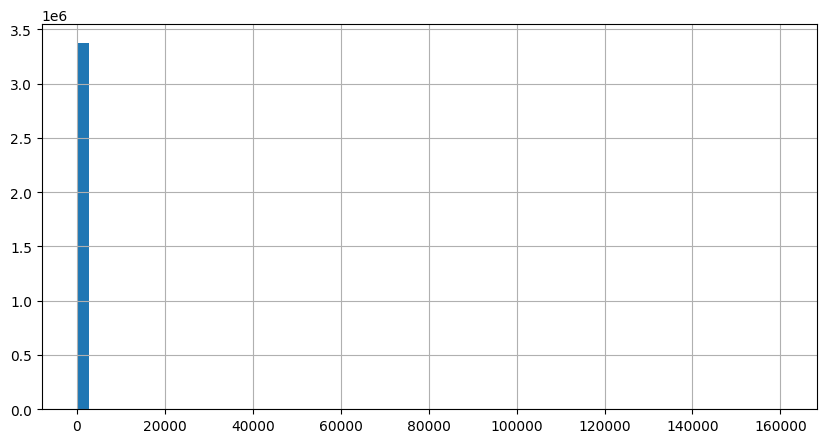

In [26]:

taxi_data_prepared["trip_distance"].hist(figsize=(10, 5), bins=60)
print(taxi_data_prepared[taxi_data_prepared["trip_distance"] > 100].shape)
# print(taxi_data_prepared["trip_distance"].nsmallest(n=100))

In [27]:

# filter out on trip_distance

print(taxi_data_prepared.shape)
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared["trip_distance"].between(0, 100)]
print(taxi_data_prepared.shape)

(3377317, 14)
(3377295, 14)


In [28]:

# Note down categorical and numerical features
categorical_columns = [
    "PULocationID",
    "transaction_date",
    "transaction_month",
    "transaction_day",
    "transaction_hour",
]
numerical_columns = ["trip_distance", "total_amount"]
all_needed_columns = categorical_columns + numerical_columns

In [29]:

main_taxi_df: pd.DataFrame = pd.DataFrame(taxi_data_prepared[all_needed_columns])
print(main_taxi_df.shape)
main_taxi_df.head()

(3377295, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,162,2024-10-01,10,1,0,3.0,24.9
1,48,2024-10-01,10,1,0,2.2,23.0
2,142,2024-10-01,10,1,0,2.7,22.2
3,233,2024-10-01,10,1,0,3.1,21.2
4,262,2024-10-01,10,1,0,0.0,8.0


Now, Aggregate data points
Now it's a good time to think about what we want to predict. We need to transform our data to a certain format

In [30]:

taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region["count_of_transactions"] = main_taxi_df.groupby(categorical_columns).count().reset_index()["total_amount"]
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(79836, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2024-10-01,10,1,11,0.00,139.2,1
1,1,2024-10-01,10,1,14,0.00,101.0,1
2,1,2024-10-01,10,1,15,0.00,146.0,1
3,1,2024-10-01,10,1,16,0.00,85.5,2
4,1,2024-10-01,10,1,17,0.12,138.0,1


<Axes: >

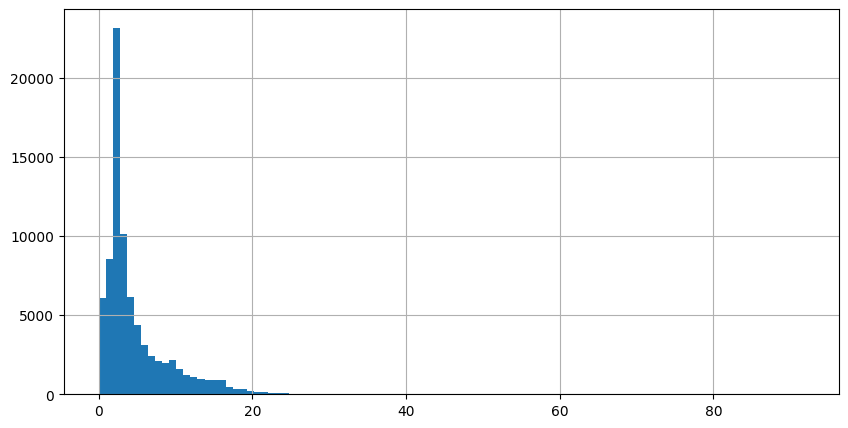

In [31]:

taxi_grouped_by_region["trip_distance"].hist(bins=100, figsize=(10, 5))

<Axes: >

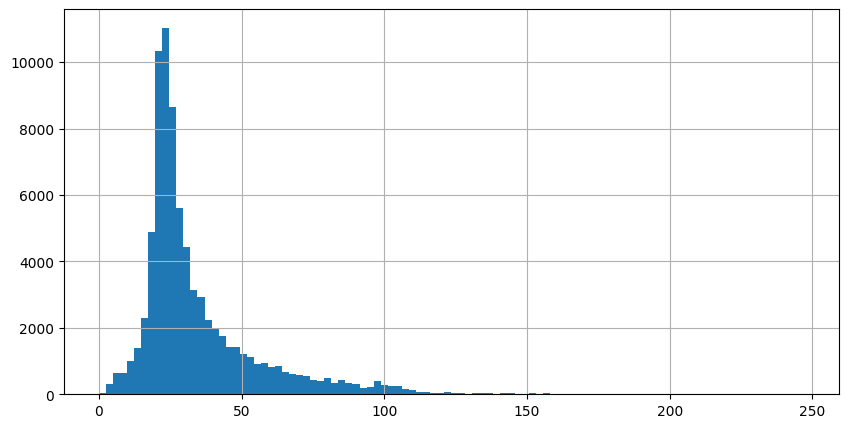

In [32]:

taxi_grouped_by_region["total_amount"].hist(bins=100, figsize=(10, 5))

### 6. Benchmark Model

In [33]:
data_from_benchmark_model = taxi_grouped_by_region.copy()

In [34]:
categorical_features_benchmark = [
    "PULocationID",
    "transaction_month",
    "transaction_day",
    "transaction_hour",
]
# do NOT include trip_distance here, since it directly coorelates with total_amount, and that's cheating actually!
input_features_benchmark = categorical_features_benchmark
target_feature_benchmark = "total_amount"

#### 6.1. Train Test Split

In [35]:

X_bench = data_from_benchmark_model[input_features_benchmark]
y_bench = data_from_benchmark_model[target_feature_benchmark]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.2, random_state=50)

#### 6.2. Fit a model into the data

In [36]:

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(max_depth=10)

#### 6.3. Model evalution

In [37]:

model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

print("mean absolute error", mean_absolute_error(y_test_b, y_pred_b))
print("mean squared error", mean_squared_error(y_test_b, y_pred_b))
print("root mean squared error", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("r2", r2_score(y_test_b, y_pred_b))

mean absolute error 12.616090392101823
mean squared error 357.68911713379254
root mean squared error 18.91267080911082
r2 0.2347719420857315


<Axes: xlabel='true', ylabel='pred'>

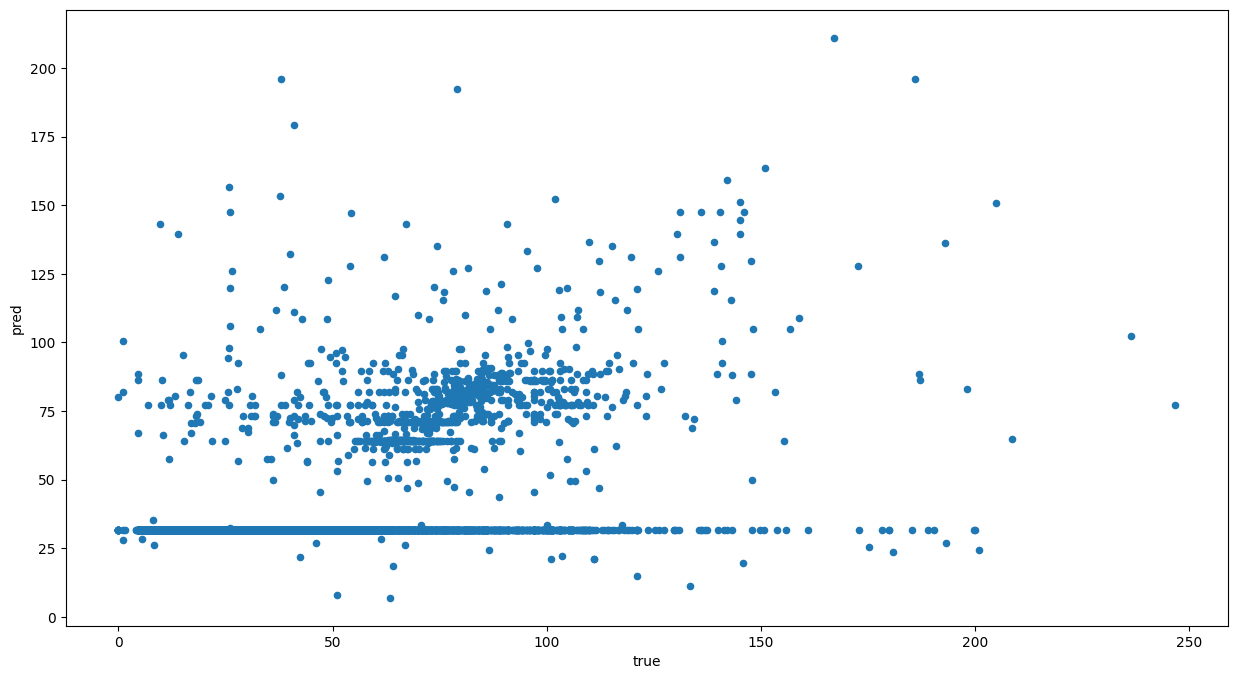

In [38]:
data = {"true": y_test_b, "pred": y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(15, 8), kind="scatter", x="true", y="pred")

### 7. Feature Engineering

In [39]:

data_with_new_features: pd.DataFrame = taxi_grouped_by_region.copy()

#### 7.1 Date-related features

In [40]:
data_with_new_features["transaction_week_day"] = data_with_new_features["transaction_date"].dt.weekday
data_with_new_features["weekend"] = data_with_new_features["transaction_week_day"].apply(lambda x: True if x in (5, 6) else False)

In [41]:

from pandas.tseries.holiday import USFederalHolidayCalendar  # noqa: E402

cal = USFederalHolidayCalendar()
holidays = pd.to_datetime(cal.holidays(start="2024", end="2025").date)  # type: ignore
data_with_new_features["is_holiday"] = data_with_new_features["transaction_date"].isin(holidays)

print(data_with_new_features["weekend"].value_counts())
print(data_with_new_features["is_holiday"].value_counts())
data_with_new_features.head()

weekend
False    60222
True     19614
Name: count, dtype: int64
is_holiday
False    77493
True      2343
Name: count, dtype: int64


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2024-10-01,10,1,11,0.00,139.2,1,1,False,False
1,1,2024-10-01,10,1,14,0.00,101.0,1,1,False,False
2,1,2024-10-01,10,1,15,0.00,146.0,1,1,False,False
3,1,2024-10-01,10,1,16,0.00,85.5,2,1,False,False
4,1,2024-10-01,10,1,17,0.12,138.0,1,1,False,False


#### 7.2 Borough Information

In [42]:

zone_lookup = pd.read_csv("data/taxi_zone_lookup.csv")
zone_lookup = zone_lookup[["LocationID", "Borough"]]
zone_lookup["LocationID"] = zone_lookup["LocationID"].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [43]:
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on="PULocationID", right_on="LocationID", how="left")
data_with_new_features.drop("LocationID", axis=1, inplace=True)
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2024-10-01,10,1,11,0.00,139.2,1,1,False,False,EWR
1,1,2024-10-01,10,1,14,0.00,101.0,1,1,False,False,EWR
2,1,2024-10-01,10,1,15,0.00,146.0,1,1,False,False,EWR
3,1,2024-10-01,10,1,16,0.00,85.5,2,1,False,False,EWR
4,1,2024-10-01,10,1,17,0.12,138.0,1,1,False,False,EWR


In [44]:
data_with_new_features["Borough"].value_counts()

Borough
Manhattan        42365
Brooklyn         15354
Queens           15210
Bronx             5159
Unknown            709
EWR                302
Staten Island      100
Name: count, dtype: int64

#### 7.3 Weather related information

In [ ]:

# Don't have the weather dataset

### 8. Model Training

In [45]:

data_for_model = data_with_new_features.copy()

In [46]:

categorical_features = [
    "PULocationID",
    "transaction_month",
    "transaction_day",
    "transaction_hour",
    "transaction_week_day",
    "weekend",
    "is_holiday",
    "Borough",
]
input_features = categorical_features
target_feature = "total_amount"

#### 8.1 Train Test Split

In [47]:

X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=80)

Index(['transaction_month', 'transaction_day', 'transaction_hour',
       'transaction_week_day', 'weekend', 'is_holiday', 'PULocationID_1',
       'PULocationID_10', 'PULocationID_100', 'PULocationID_101',
       ...
       'PULocationID_96', 'PULocationID_97', 'PULocationID_98',
       'Borough_Bronx', 'Borough_Brooklyn', 'Borough_EWR', 'Borough_Manhattan',
       'Borough_Queens', 'Borough_Staten Island', 'Borough_Unknown'],
      dtype='object', length=274)


### 8.2 Decision Tree

In [48]:

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [49]:
model_at_hand = tree

y_pred = model_at_hand.predict(X_test)

print("mean absolute error", mean_absolute_error(y_test, y_pred))
print("mean squared error", mean_squared_error(y_test, y_pred))
print("root mean squared error", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2", r2_score(y_test, y_pred))

mean absolute error 10.783878031106811
mean squared error 311.78845222804676
root mean squared error 17.657532450148484
r2 0.35945749526697246


<Axes: xlabel='true', ylabel='pred'>

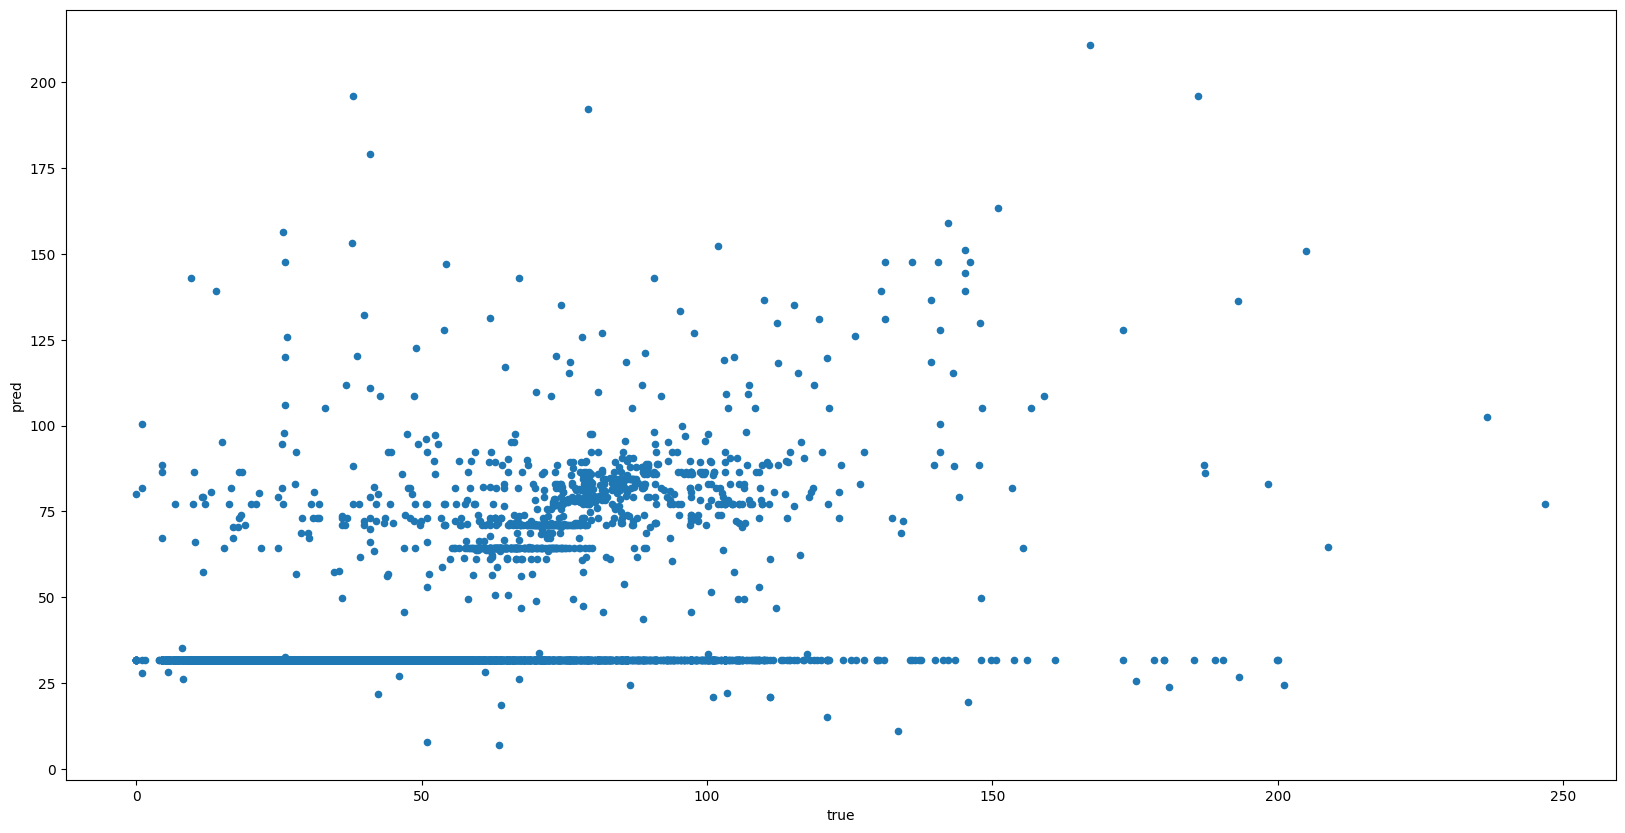

In [50]:
data = {"true": y_test_b, "pred": y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20, 10), kind="scatter", x="true", y="pred")

#### 8.3 Random Forest

In [61]:

model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [62]:

model_at_hand = model

y_pred = model_at_hand.predict(X_test)

print("mean absolute error", mean_absolute_error(y_test, y_pred))
print("mean squared error", mean_squared_error(y_test, y_pred))
print("root mean squared error", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2", r2_score(y_test, y_pred))

mean absolute error 9.826098301626619
mean squared error 290.226536256168
root mean squared error 17.036036400999148
r2 0.40375459339480335


<Axes: xlabel='true', ylabel='pred'>

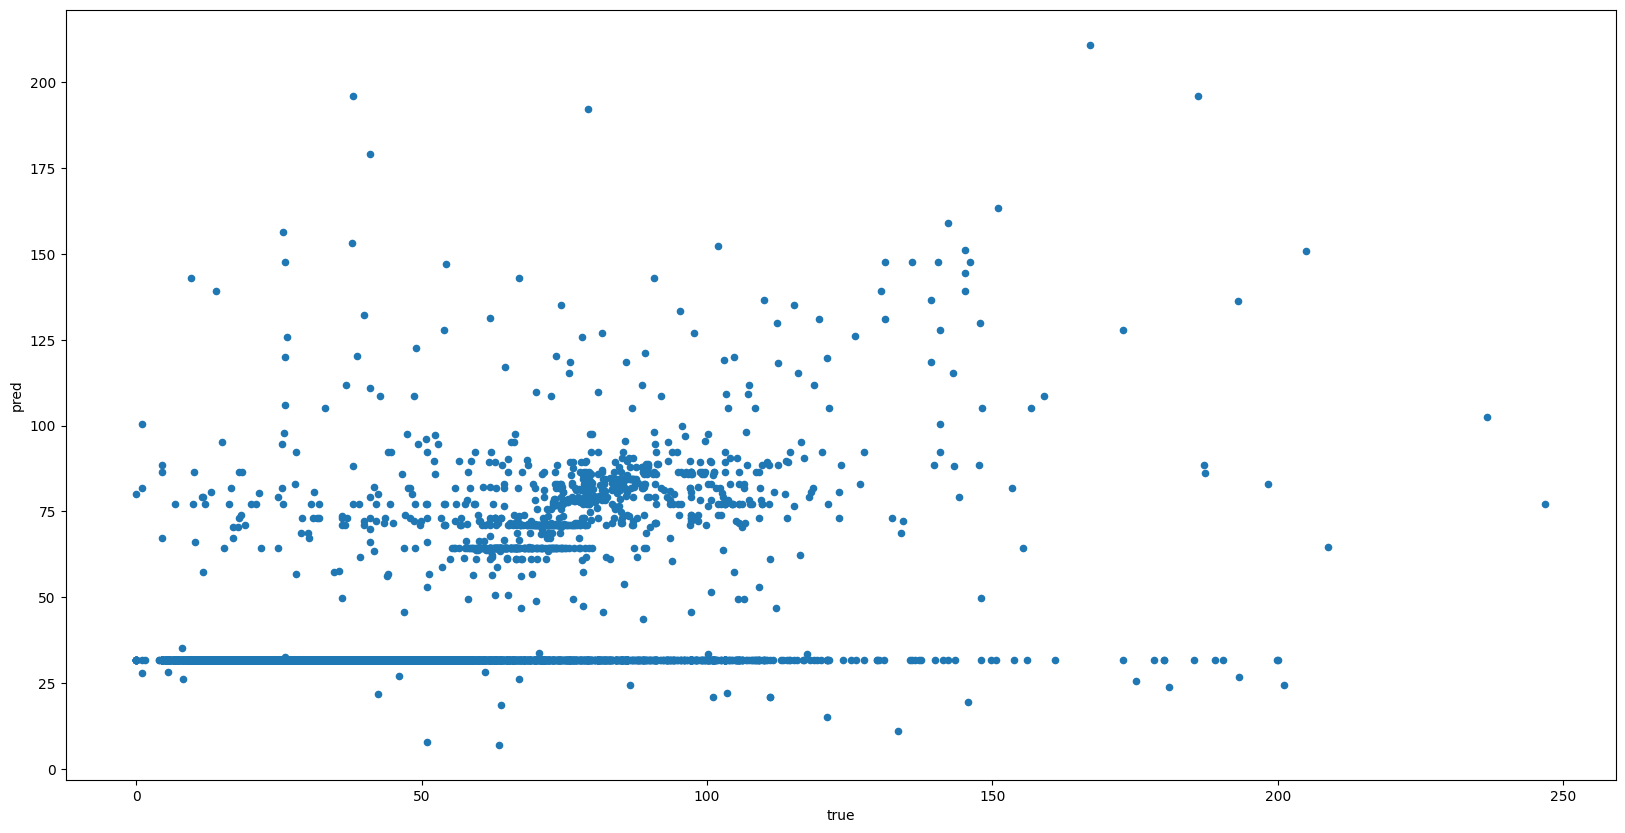

In [63]:
data = {"true": y_test_b, "pred": y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20, 10), kind="scatter", x="true", y="pred")

#### 8.4 Gradient Boosting

In [64]:

model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

HistGradientBoostingRegressor()

In [65]:

model_at_hand = model

y_pred = model_at_hand.predict(X_test)

print("mean absolute error", mean_absolute_error(y_test, y_pred))
print("mean squared error", mean_squared_error(y_test, y_pred))
print("root mean squared error", np.sqrt(mean_squared_error(y_test, y_pred)))
print("r2", r2_score(y_test, y_pred))

mean absolute error 9.622358591193198
mean squared error 254.65874857744637
root mean squared error 15.958030848994069
r2 0.47682554789852327


<Axes: xlabel='true', ylabel='pred'>

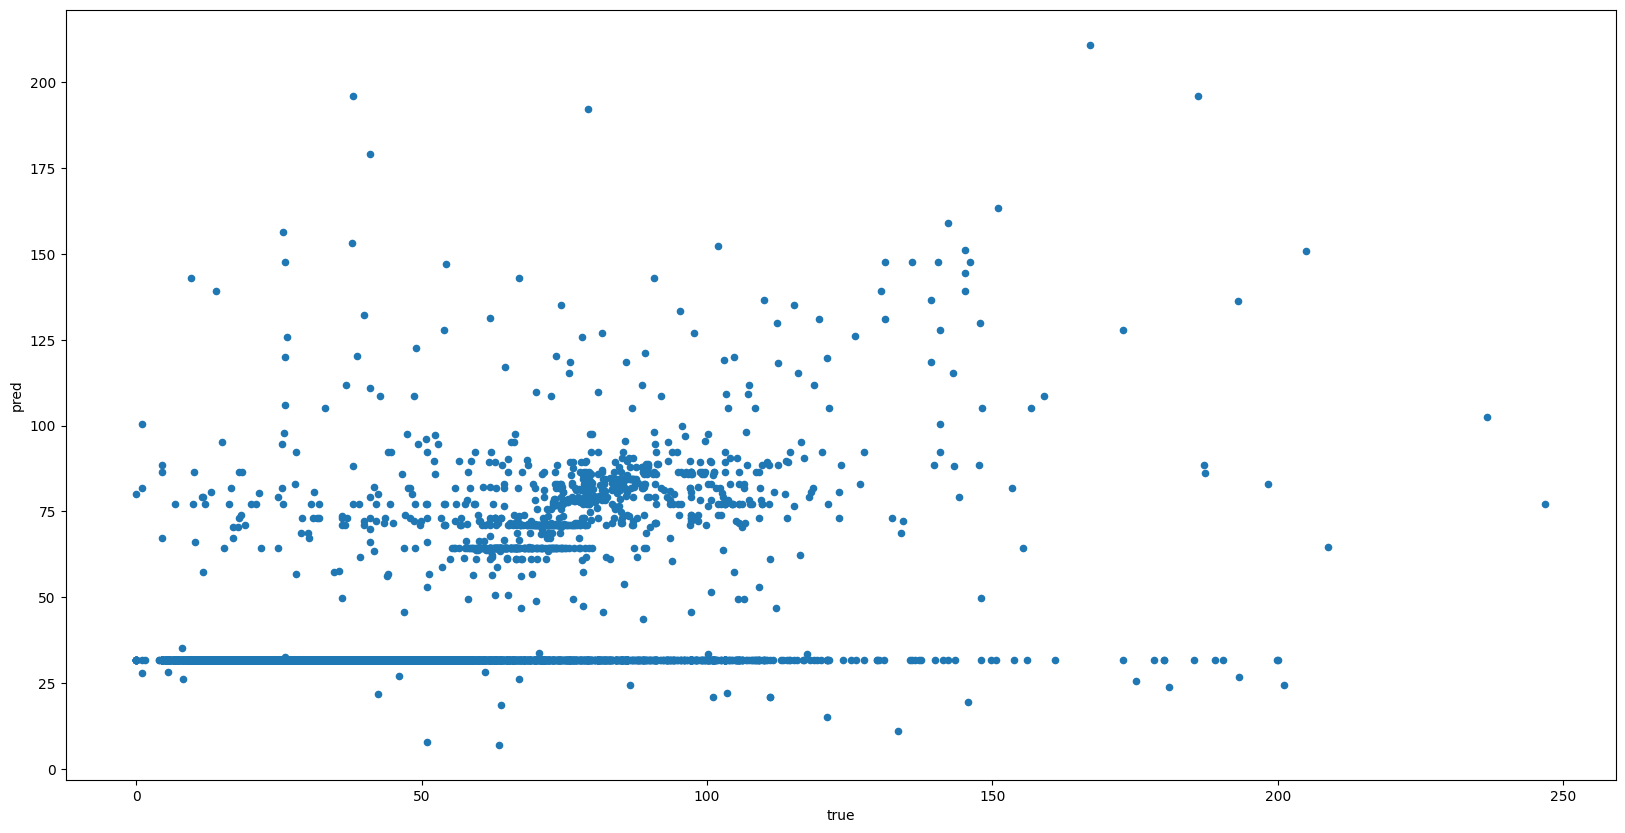

In [66]:
data = {"true": y_test_b, "pred": y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20, 10), kind="scatter", x="true", y="pred")

#### 8.5 Comparing Algorithm Performances

| Algorithm             |       MAE |      RMSE |        R2 |
|:----------------------|----------:|----------:|----------:|
| Benchmark Model       |     12.61 |     18.90 |      0.23 |
| Decision Tree         |     10.78 |     17.64 |      0.36 |
| Random Forest         |      9.82 |     17.04 |      0.40 |
| Hist Gradient Boosting|      9.62 |     15.95 |      0.47 |


#### 9. Save the Model

In [67]:

with open("taxi_regression_model.pkl", "wb") as file:
    pickle.dump(model_at_hand, file)

### 10. Tuning

#### 10.1 Find Best Parameters

In [ ]:
# Will do these. They take time!

### 11. Classification

<Axes: >

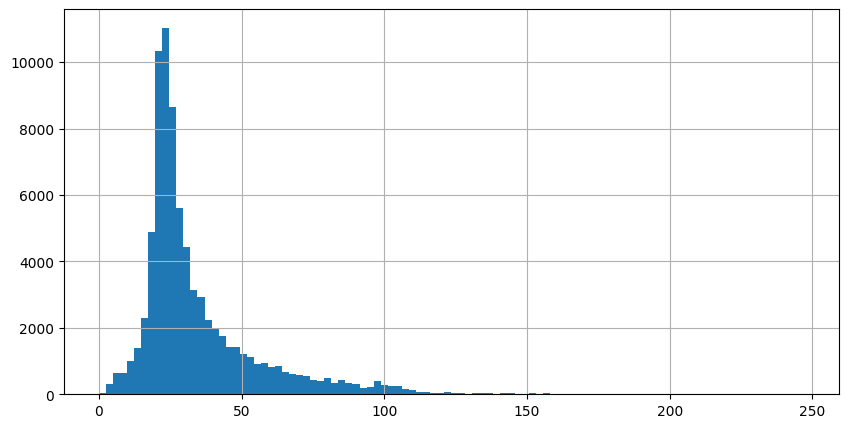

In [68]:
# Yes, we will turn this into a classification problem
data_with_new_features["total_amount"].hist(bins=100, figsize=(10, 5))

In [69]:

nyc_class = data_with_new_features.copy()
# a 20 split point is good enough!
nyc_class["earning_class"] = data_with_new_features["total_amount"].apply(lambda x: "low" if x <= 25 else "high")
nyc_class["earning_class_binary"] = nyc_class["earning_class"].apply(lambda x: 0 if x == "low" else 1)
nyc_class.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,earning_class,earning_class_binary
0,1,2024-10-01,10,1,11,0.00,139.2,1,1,False,False,EWR,high,1
1,1,2024-10-01,10,1,14,0.00,101.0,1,1,False,False,EWR,high,1
2,1,2024-10-01,10,1,15,0.00,146.0,1,1,False,False,EWR,high,1
3,1,2024-10-01,10,1,16,0.00,85.5,2,1,False,False,EWR,high,1
4,1,2024-10-01,10,1,17,0.12,138.0,1,1,False,False,EWR,high,1


In [70]:
nyc_class["earning_class"].value_counts()

earning_class
high    45671
low     34165
Name: count, dtype: int64

In [71]:

categorical_features = [
    "PULocationID",
    "transaction_month",
    "transaction_day",
    "transaction_hour",
    "transaction_week_day",
    "weekend",
    "is_holiday",
    "Borough",
]
input_features = categorical_features
target_feature = "earning_class_binary"

In [72]:

X_c = nyc_class[input_features]
y_c = nyc_class[target_feature]

# one-hot encode
X_c = pd.get_dummies(X_c)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.33, random_state=100)

In [73]:

clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c)

RandomForestClassifier()

In [74]:

y_pred_c = clf.predict(X_test_c)

print(confusion_matrix(y_test_c, y_pred_c))
print("accuracy", accuracy_score(y_test_c, y_pred_c))
print("precision", precision_score(y_test_c, y_pred_c))
print("recall", recall_score(y_test_c, y_pred_c))

[[ 7600  3717]
 [ 3313 11716]]
accuracy 0.7331663250588325
precision 0.759152465496015
recall 0.7795595182646883


### 12. Save Classification Model

In [75]:

with open("taxi_classification_model.pkl", "wb") as file:
    pickle.dump(clf, file)